# Crop the Planet Image

This notebook shows how to crop the planet image.

In [1]:
import geopandas as gpd
import os
import rasterio
import rasterio.mask
from pathlib import Path
from rasterio.plot import show
from rasterio.crs import CRS
import matplotlib.pyplot as plt
import pandas as pd

# Parameters

Specify *exactly* one. The `site_name` or the `planet_id`. The former is given to the chip by the validation team. Because we are not selecting multiple planet scenes per chip and not selecting planet images that cover multiple chips (they are sufficiently spaced apart), this should be a 1 to 1 mapping.

In [2]:
PLANET_ID = ''
SITE_NAME = '3_28'

# ^ is exclusive or; makes sure you only specified one
assert((len(PLANET_ID) == 0) ^ (len(SITE_NAME) == 0))

# Environment

In [3]:
os.environ["AWS_NO_SIGN_REQUEST"] = "YES"

# Get Image Database

In [4]:
df_images = gpd.read_file('s3://opera-calval-database-dswx/image.geojson')
df_images.dropna(inplace=True)
df_images.head()

,collocated_dswx,dswx_cloud_cover,datetime,image_name,cloud_cover,site_coverage,instrument,provider,resolution,timeDelta_days,site_name,Strata,geometry
0,HLS.S30.T04WDB.2021271T225541.v2.0,4.0,2021-09-29 21:28:09.168000+00:00,20210929_212809_16_2442,0.0,90.820013,PSB.SD,planetscope,3.0,0.938606,3_38,3.0,"POLYGON ((-160.00896 69.30478, -160.21043 69.1..."
1,HLS.S30.T33WXP.2021270T104719.v2.0,16.0,2021-09-27 09:55:37.877000+00:00,20210927_095537_0f15,0.0,41.216128,PS2,planetscope,3.0,0.039303,4_43,4.0,"POLYGON ((17.22275 66.09223, 17.16459 66.02168..."
2,HLS.L30.T40WFU.2021268T073033.v2.0,2.0,2021-09-25 07:27:12.166000+00:00,20210925_072712_16_2254,0.0,72.272530,PSB.SD,planetscope,3.0,0.002335,3_1,3.0,"POLYGON ((59.00446 65.95517, 58.85023 65.76646..."
3,HLS.S30.T14VPQ.2021244T175911.v2.0,2.0,2021-09-01 17:52:05.712000+00:00,20210901_175205_71_2426,0.0,100.000000,PSB.SD,planetscope,3.0,0.010000,4_34,4.0,"POLYGON ((-96.94381 62.88876, -97.07609 62.707..."
4,HLS.S30.T52VFP.2021253T023549.v2.0,2.0,2021-09-11 00:51:29.821000+00:00,20210911_005129_82_106a,0.0,100.000000,PS2.SD,planetscope,3.0,0.924389,3_30,3.0,"POLYGON ((130.86458 61.50211, 130.95358 61.357..."


In [5]:
df_site = gpd.read_file('s3://opera-calval-database-dswx/site.geojson')
df_site.dropna(inplace=True)
df_site.head()

,site_name,water_content,geometry
0,3_38,3.0,"POLYGON ((-159.78489 69.25969, -159.65899 69.2..."
1,4_27,4.0,"POLYGON ((-113.10838 67.09964, -113.09840 67.0..."
2,4_43,4.0,"POLYGON ((17.61007 66.01963, 17.81779 66.01970..."
3,3_1,3.0,"POLYGON ((59.55613 65.74045, 59.55651 65.83973..."
4,4_34,4.0,"POLYGON ((-96.71059 62.77966, -96.57702 62.779..."


In [6]:
cols_to_merge = [col for col in df_images.columns if col != 'geometry']
df_temp = df_images[cols_to_merge]
df_chips = pd.merge(df_site, df_temp , on='site_name', how='left')
df_chips.head()

,site_name,water_content,geometry,collocated_dswx,dswx_cloud_cover,datetime,image_name,cloud_cover,site_coverage,instrument,provider,resolution,timeDelta_days,Strata
0,3_38,3.0,"POLYGON ((-159.78489 69.25969, -159.65899 69.2...",HLS.S30.T04WDB.2021271T225541.v2.0,4.0,2021-09-29 21:28:09.168000+00:00,20210929_212809_16_2442,0.0,90.820013,PSB.SD,planetscope,3.0,0.938606,3.0
1,4_27,4.0,"POLYGON ((-113.10838 67.09964, -113.09840 67.0...",NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4_43,4.0,"POLYGON ((17.61007 66.01963, 17.81779 66.01970...",HLS.S30.T33WXP.2021270T104719.v2.0,16.0,2021-09-27 09:55:37.877000+00:00,20210927_095537_0f15,0.0,41.216128,PS2,planetscope,3.0,0.039303,4.0
3,3_1,3.0,"POLYGON ((59.55613 65.74045, 59.55651 65.83973...",HLS.L30.T40WFU.2021268T073033.v2.0,2.0,2021-09-25 07:27:12.166000+00:00,20210925_072712_16_2254,0.0,72.272530,PSB.SD,planetscope,3.0,0.002335,3.0
4,4_34,4.0,"POLYGON ((-96.71059 62.77966, -96.57702 62.779...",HLS.S30.T14VPQ.2021244T175911.v2.0,2.0,2021-09-01 17:52:05.712000+00:00,20210901_175205_71_2426,0.0,100.000000,PSB.SD,planetscope,3.0,0.010000,4.0


/var/folders/s6/fbsc26cd0ddffbp3_knts_9c0wcxj1/T/ipykernel_38789/1739921028.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_chips.buffer(2).plot()


<AxesSubplot:>

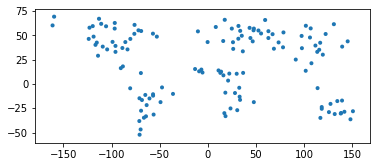

In [7]:
df_chips.buffer(2).plot()

In [8]:
temp = df_chips[['image_name', 'site_name']]
df_site2image = temp.set_index('site_name')
df_image2site = temp.set_index('image_name')
df_site2image.head()

,image_name
site_name,
3_38,20210929_212809_16_2442
4_27,NaN
4_43,20210927_095537_0f15
3_1,20210925_072712_16_2254
4_34,20210901_175205_71_2426


In [9]:
if not PLANET_ID:
    values = PLANET_ID = df_site2image.loc[SITE_NAME].tolist()
    PLANET_ID = values[0]
    print(f'There was {len(values)} planet images for this chip')
else:
    values = df_image2site.loc[PLANET_ID].tolist()
    SITE_NAME = values[0]
    print(f'There were {len(values)} chips for this planet_image')

(SITE_NAME, PLANET_ID)

There was 1 planet images for this chip


('3_28', '20210906_101112_28_225a')

In [10]:
df_chips.to_file('chips.geojson', driver='GeoJSON')

# Crop

In [11]:
data_dir = Path(f'data/{PLANET_ID}/')
data_dir.mkdir(exist_ok=True, parents=True)

In [12]:
n = len(PLANET_ID)
planet_images = list(data_dir.glob('*.tif'))
planet_image_path = list(filter(lambda x: x.name[:n] == PLANET_ID, planet_images))[0]
planet_image_path

PosixPath('data/20210906_101112_28_225a/20210906_101112_28_225a_3B_AnalyticMS_SR_8b.tif')

In [13]:
with rasterio.open(planet_image_path) as ds:
    planet_crs = ds.crs

<AxesSubplot:>

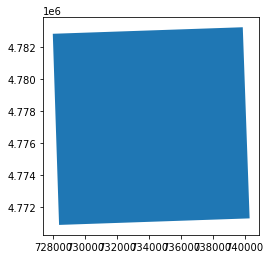

In [14]:
df_chip = df_chips[df_chips.image_name == PLANET_ID]

# 500 meter buffer
df_chip_utm = df_chip.to_crs(planet_crs).buffer(500, join_style=2)
df_chip_utm.plot()

In [15]:
with rasterio.open(planet_image_path) as src:
    out_image, out_transform = rasterio.mask.mask(src, df_chip_utm.geometry, crop=True)
    out_meta = src.meta

out_meta.update({"driver": "GTiff",
         "height": out_image.shape[1],
         "width": out_image.shape[2],
         "transform": out_transform})

with rasterio.open(data_dir / f'cropped_{PLANET_ID}.tif', "w", **out_meta) as dest:
    dest.write(out_image)

# Check

<AxesSubplot:>

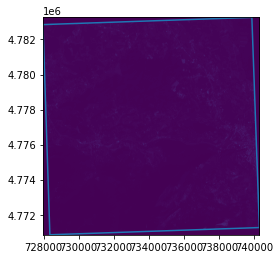

In [16]:
fig, ax = plt.subplots()
show(out_image[0,...], transform=out_transform, ax=ax)
df_chip_utm.boundary.plot(ax=ax)